In [1]:
import glob
import numpy as np
import pandas as pd


def aggregate_csv_files(directory_path):
    all_files = glob.glob(f"{directory_path}/*.csv")
    df_list = []

    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)

    # Concatenate all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)

    # Drop rows with NaN or infinite values
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_df.dropna(inplace=True)

    # Select the necessary columns
    aggregated_df = combined_df[
        [
            "date",
            "1wk_WIS",
            "1_week_roc",
            "is_wis_above_avg",
            "1st_deriv_stencil",
            "week_of_year",
            "moving_avg_WIS",
            "lagged_1wk_WIS",
        ]
    ]

    return aggregated_df


directory_path = "./hosp_roc"
aggregated_data = aggregate_csv_files(directory_path)
aggregated_data.head(30)

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS
2,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51
3,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51
4,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51
5,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84
6,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54
7,2023-12-02,9.01,0.642857,0,31.333333,48,19.303333,37.36
8,2023-12-09,6.52,0.057971,0,29.166667,49,17.630000,9.01
9,2023-12-16,15.34,0.417808,0,69.083333,50,10.290000,6.52
10,2023-12-23,20.43,0.381643,0,121.750000,51,14.096667,15.34
11,2023-12-30,192.22,0.500000,1,100.333333,52,75.996667,20.43


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

df = aggregated_data
df.dropna(inplace=True)

features = [
    "1_week_roc",
    "1st_deriv_stencil",
    "week_of_year",
    "moving_avg_WIS",
    "lagged_1wk_WIS",
]
X = df[features]
y = df["is_wis_above_avg"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model training
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       155
           1       0.74      0.36      0.49        69

    accuracy                           0.76       224
   macro avg       0.75      0.65      0.67       224
weighted avg       0.76      0.76      0.74       224

ROC-AUC: 0.7712014960261805


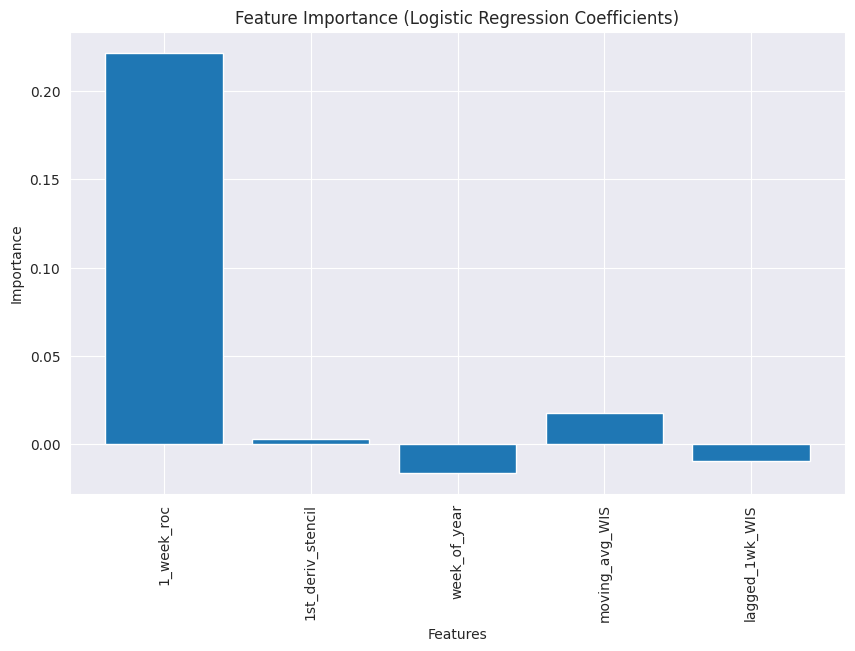

In [5]:
import matplotlib.pyplot as plt

# Extract feature importance (coefficients for logistic regression)
importance = log_reg.coef_[0]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), features, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()

In [6]:
print(importance)

[ 0.22151769  0.00307964 -0.01608085  0.01778    -0.00923378]


In [7]:
"""Recursive Feature Elimination"""

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model
model = LogisticRegression()

# Initialize RFE with the logistic regression model
rfe = RFE(model, n_features_to_select=3)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['1_week_roc', 'week_of_year', 'moving_avg_WIS'], dtype='object')


In [8]:
df = aggregated_data
df.dropna(inplace=True)

features = ["1_week_roc", "week_of_year", "moving_avg_WIS"]
X = df[features]
y = df["is_wis_above_avg"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model training
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predictions and evaluation
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84       155
           1       0.71      0.29      0.41        69

    accuracy                           0.75       224
   macro avg       0.73      0.62      0.62       224
weighted avg       0.74      0.75      0.71       224

ROC-AUC: 0.7245441795231415


## Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       155
           1       0.69      0.64      0.66        69

    accuracy                           0.80       224
   macro avg       0.77      0.75      0.76       224
weighted avg       0.80      0.80      0.80       224



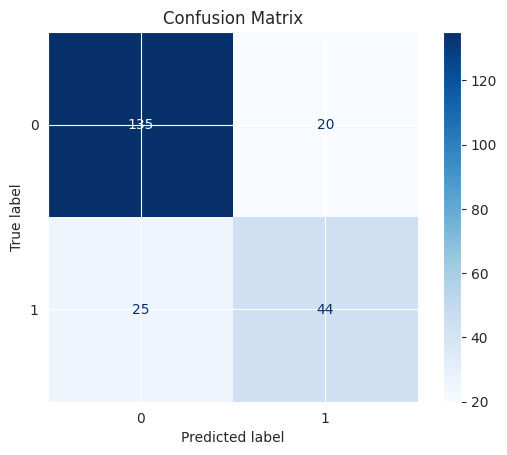

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

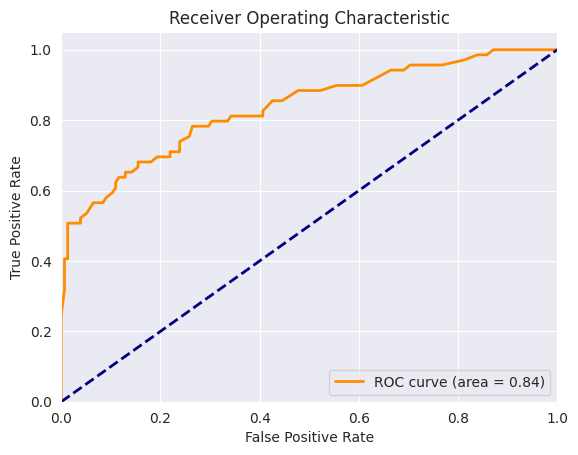

In [11]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [12]:
df = aggregated_data
df.dropna(inplace=True)

features = [
    "1_week_roc",
    "1st_deriv_stencil",
    "week_of_year",
    "moving_avg_WIS",
    "lagged_1wk_WIS",
]
X = df[features]
y = df["is_wis_above_avg"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       155
           1       0.75      0.67      0.71        69

    accuracy                           0.83       224
   macro avg       0.81      0.78      0.79       224
weighted avg       0.83      0.83      0.83       224

